In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
from torchvision import models

In [2]:
import cv2
import matplotlib.pyplot as plt
targetsize =(200,200)
kernel = np.ones((3,3), np.uint8)

In [3]:
  def preprocess_input_img(test_image_path):
    '''
    This function takes the path to the input test image
    and returns a preprocessed image (which can be used as a input to the model)
    (Input): Single test image path
    (Output): Preprocessed image
    '''

    # Read the original test image
    orig_sample_test_img = cv2.cvtColor(cv2.imread(test_image_path), cv2.COLOR_BGR2RGB)
    x = 50
    y = 0
    width = 200
    height = 200

# Crop the image
    orig_sample_test_img = orig_sample_test_img[y:y+height, x:x+width]
    # Convert image to gray scale
    gray_sample_test_img = cv2.cvtColor(orig_sample_test_img, cv2.COLOR_RGB2GRAY)

    # Resizing image to desired input size
    gray_resized_test_img = cv2.resize(gray_sample_test_img, targetsize,
                        interpolation = cv2.INTER_AREA)   # To shrink an image

    # Remove blemishes from image (if any)
    # Remove blemishes from image (if any)
    (thresh, black_n_white_sample_img) = cv2.threshold(gray_resized_test_img, 70,255, cv2.THRESH_BINARY_INV)
#     black_n_white_sample_img =cv2.GaussianBlur(black_n_white_sample_img , (3, 3), 0)
    black_n_white_sample_img= cv2.dilate(black_n_white_sample_img, kernel, iterations=1)

    _, black_n_white_sample_img = cv2.threshold(black_n_white_sample_img, 50, 255, cv2.THRESH_BINARY)
    black_n_white_sample_img = black_n_white_sample_img/255
    # Display Images	: Plot Sample Input and Preprocessed Test Image

#     f = plt.figure(figsize=(10,5))
#     ax1 = f.add_subplot(121)
#     ax2 = f.add_subplot(122)

#     ax1.imshow(np.squeeze(orig_sample_test_img), cmap='gray')
#     ax1.set_title("Original Test Input Image", pad=15, fontsize=13, fontweight='bold')
#     ax2.imshow(np.squeeze(black_n_white_sample_img), cmap='gray')
#     ax2.set_title("Preprocessed Test Input Image", pad=15, fontsize=13, fontweight='bold')
#     plt.tight_layout()
#     plt.show()

    return orig_sample_test_img, black_n_white_sample_img

In [4]:
def load_image(image_path, target_size=targetsize):
    _,img = preprocess_input_img(image_path)
#     img = img/255
    transform = transforms.Compose([
#         transforms.Resize(target_size),
        transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    img = transform(img)
    img = img.float()
#     print(img.type())
    return img

In [5]:


# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, main_folder, target_size=targetsize):
        self.main_folder = main_folder
        self.target_size = target_size
        self.data = []

        for subdir, _, files in os.walk(main_folder):
#             print("=")
            if 'image_data.csv' in files:
                csv_path = os.path.join(subdir, 'image_data.csv')
                df = pd.read_csv(csv_path)
                target_image_path = os.path.join(subdir, 'target.jpg')
                for _, row in df.iterrows():
                    X2_image_path = os.path.join(subdir, row['Image_Name'])
                    self.data.append((target_image_path, X2_image_path, row['x'], row['y']))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        target_image_path, X2_image_path, y1, y2 = self.data[idx]
        target_image = load_image(target_image_path, self.target_size)
        X2_image = load_image(X2_image_path, self.target_size)
        return (target_image, X2_image), torch.tensor([y1, y2], dtype=torch.float32)

# Initialize dataset and dataloaders

main_folder = './processed'  # Replace with your main folder path
dataset = CustomDataset(main_folder)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [6]:

class CustomResNet(nn.Module):
    def __init__(self, num_outputs=2):
        super(CustomResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=False)
        self.c1 = nn.Conv2d(1, 8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
        self.c2 = nn.Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
        self.c3 = nn.Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)

        self.resnet.conv1 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), bias=False)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()
        self.fc1 = nn.Linear(num_ftrs * 2, 512)
        self.r = nn.ReLU(inplace=True)
        self.fc11 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 8)
        self.fc7 = nn.Linear(8, num_outputs   )
        self.fc8 = nn.Linear(8, 1)

        self.d = nn.Dropout(0.2)
        self.tanh = nn.Tanh()

    def forward(self, x1, x2):
        x1 = self.c1(x1)
        x1 = self.c2(x1)
        x1 = self.c3(x1)

        x2 = self.c1(x2)
        x2 = self.c2(x2)
        x2 = self.c3(x2)

        f1 = self.resnet(x1)
        f2 = self.resnet(x2)
        combined = torch.cat((f1, f2), dim=1)
        x = nn.ReLU()(self.fc1(combined))
        x = self.d(x)
        x = nn.ReLU()(self.fc11(x))
        x = self.d(x)
        x = nn.ReLU()(self.fc2(x))
        x = self.d(x)
        x = nn.ReLU()(self.fc3(x))
        x = self.d(x)
        x = nn.ReLU()(self.fc4(x))
        x = self.d(x)
        x = nn.ReLU()(self.fc5(x))
        x = self.d(x)
        x = nn.ReLU()(self.fc6(x))
        y = self.tanh(self.fc7(x))
#         z = self.tanh(self.fc8(x))
        return y

# Initialize the model
model = CustomResNet()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


CustomResNet(
  (resnet): ResNet(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [7]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [8]:
from torchsummary import summary

summary(model, [(1, 200, 200), (1, 200, 200)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 201, 201]              32
            Conv2d-2         [-1, 16, 202, 202]             512
            Conv2d-3         [-1, 32, 203, 203]           2,048
            Conv2d-4          [-1, 8, 201, 201]              32
            Conv2d-5         [-1, 16, 202, 202]             512
            Conv2d-6         [-1, 32, 203, 203]           2,048
            Conv2d-7         [-1, 64, 104, 104]          18,432
       BatchNorm2d-8         [-1, 64, 104, 104]             128
              ReLU-9         [-1, 64, 104, 104]               0
        MaxPool2d-10           [-1, 64, 52, 52]               0
           Conv2d-11           [-1, 64, 52, 52]          36,864
      BatchNorm2d-12           [-1, 64, 52, 52]             128
             ReLU-13           [-1, 64, 52, 52]               0
           Conv2d-14           [-1, 64,

In [19]:
def save_results(epoch, train_loss, val_loss, train_mae, val_mae, train_accuracy, val_accuracy, output_dir):
    with open(os.path.join(output_dir, 'training_results.txt'), 'a') as f:
        f.write(f'Epoch [{epoch+1}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, '
                f'Train MAE: {train_mae:.4f}, Validation MAE: {val_mae:.4f}, '
                f'Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}\n')


# Get the current date and time
current_time = datetime.now().strftime("%Y_%m_%d-%H:%M:%S")

# Create a directory to save results using the current timestamp
output_dir = f'results_{current_time}'
os.makedirs(output_dir, exist_ok=True)

Epoch [1/50], Train Loss: 0.2597, Validation Loss: 0.2920, Train MAE: 0.3703, Validation MAE: 0.3917, Train Accuracy: 0.5348, Validation Accuracy: 0.5042
Epoch [2/50], Train Loss: 0.2743, Validation Loss: 0.3136, Train MAE: 0.3812, Validation MAE: 0.4136, Train Accuracy: 0.5277, Validation Accuracy: 0.4417
Epoch [3/50], Train Loss: 0.2552, Validation Loss: 0.2793, Train MAE: 0.3678, Validation MAE: 0.3735, Train Accuracy: 0.5376, Validation Accuracy: 0.5125
Epoch [4/50], Train Loss: 0.2483, Validation Loss: 0.3416, Train MAE: 0.3547, Validation MAE: 0.4151, Train Accuracy: 0.5558, Validation Accuracy: 0.4917
Epoch [5/50], Train Loss: 0.2997, Validation Loss: 0.3070, Train MAE: 0.4012, Validation MAE: 0.4064, Train Accuracy: 0.4844, Validation Accuracy: 0.4875
Epoch [6/50], Train Loss: 0.2658, Validation Loss: 0.2724, Train MAE: 0.3736, Validation MAE: 0.3712, Train Accuracy: 0.5290, Validation Accuracy: 0.4917
Epoch [7/50], Train Loss: 0.2351, Validation Loss: 0.3108, Train MAE: 0.3429

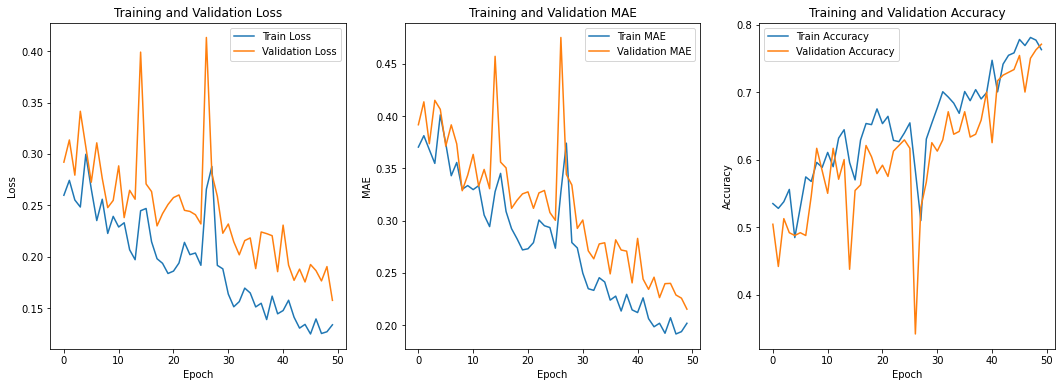

In [20]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Initialize lists to store losses, MAE, and accuracy
train_losses = []
val_losses = []
train_maes = []
val_maes = []
train_accuracies = []
val_accuracies = []

# Define MAE criterion
mae_criterion = nn.L1Loss()

# Define accuracy function
def accuracy(outputs, labels):
    preds = outputs.round()
    corrects = torch.sum(torch.all(preds == labels, dim=1)).item()
    return corrects / len(labels)

# Training loop
EPOCHS = 50
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    running_mae = 0.0
    running_corrects = 0
    for i, (inputs, labels) in enumerate(train_loader):
        (target_images, X2_images), labels = inputs, labels
        target_images, X2_images, labels = target_images.to(device), X2_images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(target_images, X2_images)
        loss = criterion(outputs, labels)
        mae = mae_criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_mae += mae.item()
        running_corrects += accuracy(outputs, labels)
#         print("=")
        
    # Store the training loss, MAE, and accuracy
    train_losses.append(running_loss / len(train_loader))
    train_maes.append(running_mae / len(train_loader))
    train_accuracies.append(running_corrects / len(train_loader))

    # Validation step
    model.eval()
    val_loss = 0.0
    val_mae = 0.0
    val_corrects = 0
    with torch.no_grad():
        for data in val_loader:
            (target_images, X2_images), labels = data
            target_images, X2_images, labels = target_images.to(device), X2_images.to(device), labels.to(device)
            outputs = model(target_images, X2_images)
            loss = criterion(outputs, labels)
            mae = mae_criterion(outputs, labels)
            val_loss += loss.item()
            val_mae += mae.item()
            val_corrects += accuracy(outputs, labels)
    
    val_losses.append(val_loss / len(val_loader))
    val_maes.append(val_mae / len(val_loader))
    val_accuracies.append(val_corrects / len(val_loader))
    
    save_results(epoch, train_losses[-1], val_losses[-1], train_maes[-1], val_maes[-1], train_accuracies[-1], val_accuracies[-1], output_dir)

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Train MAE: {train_maes[-1]:.4f}, Validation MAE: {val_maes[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.4f}')

print('Training Done')

# Plot the training and validation loss, MAE, and accuracy
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 2)
plt.plot(train_maes, label='Train MAE')
plt.plot(val_maes, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('Training and Validation MAE')

plt.subplot(1, 3, 3)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.savefig(os.path.join(output_dir, 'Training_validation_plots.png'))

plt.show()


In [21]:

total_loss = 0

with torch.no_grad():
    for data in val_loader:
        (target_images, X2_images), labels = data
        target_images, X2_images, labels = target_images.to(device), X2_images.to(device), labels.to(device)
#         print(target_images.size())
        
        outputs = model(target_images, X2_images)
#         print(outputs.size())
#         print("____\n")
        
        loss = criterion(outputs, labels)
        total_loss += loss.item()
#         correct += (predicted == labels).sum().item()

avg_loss = total_loss / len(val_loader)
print('Validation Loss: ', avg_loss)


Validation Loss:  0.1573886975646019


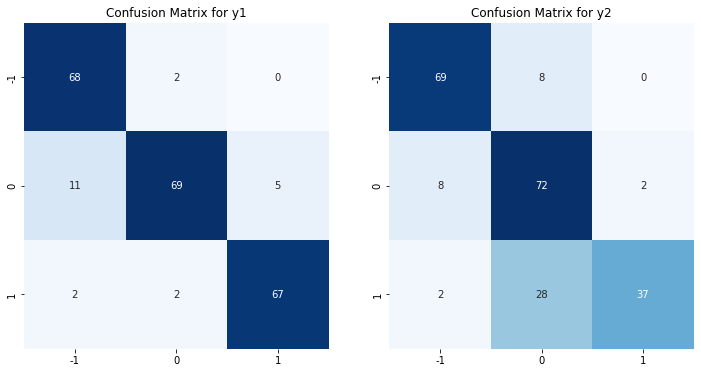

In [22]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function to convert continuous values to discrete classes
def continuous_to_discrete(y):
    y_discrete = np.zeros_like(y)
    y_discrete[y > 0.5] = 1
    y_discrete[y < -0.5] = -1
    return y_discrete

# Define a function to extract true and predicted values
def extract_true_and_predicted_values(loader, model, device):
    model.eval()
    true_y1 = []
    true_y2 = []
    pred_y1 = []
    pred_y2 = []

    with torch.no_grad():
        for data in loader:
            (target_images, X2_images), labels = data
            target_images, X2_images, labels = target_images.to(device), X2_images.to(device), labels.to(device)
            outputs = model(target_images, X2_images)

            true_y1.extend(labels[:, 0].cpu().numpy())
            true_y2.extend(labels[:, 1].cpu().numpy())
            pred_y1.extend(outputs[:, 0].cpu().numpy())
            pred_y2.extend(outputs[:, 1].cpu().numpy())

    return np.array(true_y1), np.array(pred_y1), np.array(true_y2), np.array(pred_y2)

# Extract true and predicted values
true_y1, pred_y1, true_y2, pred_y2 = extract_true_and_predicted_values(val_loader, model, device)

# Convert continuous predictions and true values to discrete classes
true_y1_discrete = continuous_to_discrete(true_y1)
pred_y1_discrete = continuous_to_discrete(pred_y1)
true_y2_discrete = continuous_to_discrete(true_y2)
pred_y2_discrete = continuous_to_discrete(pred_y2)

# print(true_y1_discrete-pred_y1_discrete)
# print()
# Generate confusion matrices
cm_y1 = confusion_matrix(true_y1_discrete, pred_y1_discrete , labels=[-1, 0, 1])
cm_y2 = confusion_matrix(true_y2_discrete, pred_y2_discrete , labels=[-1, 0, 1])

# Plot confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# ConfusionMatrixDisplay(cm_y1).plot(ax=ax[0])
sns.heatmap(cm_y1, annot=True, fmt='d', cmap='Blues', ax=ax[0], cbar=False)

ax[0].set_title('Confusion Matrix for y1')
ax[0].set_xticklabels(['-1', '0', '1'])
ax[0].set_yticklabels(['-1', '0', '1'])

# ConfusionMatrixDisplay(cm_y2).plot(ax=ax[1])
sns.heatmap(cm_y2, annot=True, fmt='d', cmap='Blues', ax=ax[1], cbar=False)

ax[1].set_title('Confusion Matrix for y2')
ax[1].set_xticklabels(['-1', '0', '1'])
ax[1].set_yticklabels(['-1', '0', '1'])
plt.show()


In [23]:
test_image_path = './processed/D9/img027.jpg'
target_image_path= './processed/D9/target.jpg'

# Load the images
target_image = load_image(target_image_path).unsqueeze(0).to(device)  # Adding batch dimension
test_image = load_image(test_image_path).unsqueeze(0).to(device)     # Adding batch dimension

print("target state image is of shape",target_image.shape)  # Expected: torch.Size([1, 1, 200, 200])
print("current state frame is of shape",test_image.shape)    # Expected: torch.Size([1, 1, 200, 200])

# Evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(target_image, test_image)
    print("model predictions",outputs)
    nparray = outputs.cpu().numpy()  # Move tensor to CPU before conversion
#     if nparray[0]<0.5 and nparray[0]>-0.5:
#         nparray[0]=0
#     if nparray[0]>0.5:
#         nparray[0]=1
#     if nparray[0]<-0.5:
#         nparray[0]=-1
    
#     print("one hot encoding",nparray.size)
    

    
    




target state image is of shape torch.Size([1, 1, 200, 200])
current state frame is of shape torch.Size([1, 1, 200, 200])
model predictions tensor([[-0.0541, -0.6156]], device='cuda:0')


In [24]:
# net = ResNet50(10).to('cuda')
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

In [25]:
torch.save(model.state_dict(), f'results_{current_time}resnet_.pth')
# torch.save(f'results_{current_time}resnet_.pth')

In [26]:
# test_image_path = './processed/D5/img021.jpg'
# target_image_path= './processed/D5/target.jpg'

# # Load and preprocess the images
# target_image = load_image(target_image_path).to(device)
# test_image = load_image(test_image_path).to(device)

# # Set the model to evaluation mode
# # model.eval()

# # Disable gradient calculation
# with torch.no_grad():
#     # Get the model's output
#     output = model(target_image, test_image)

# # Print the output
# print('Model Output:', output)

In [27]:
# EPOCHS = 30
# for epoch in range(EPOCHS):
#     model.train()
#     running_loss = 0.0
#     for i, (inputs, labels) in enumerate(train_loader):
#         (target_images, X2_images), labels = inputs, labels
#         target_images, X2_images, labels = target_images.to(device), X2_images.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(target_images, X2_images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
        
#         if i % 10 == 0 and i > 0:
#             print(f'Loss [{epoch+1}, {i}](epoch, minibatch): ', running_loss / 100)
#             running_loss = 0.0

# print('Training Done')

# # Validation loop
# model.eval()
# correct = 0
# total = 0

# with torch.no_grad():
#     for data in val_loader:
#         (target_images, X2_images), labels = data
#         target_images, X2_images, labels = target_images.to(device), X2_images.to(device), labels.to(device)
#         outputs = model(target_images, X2_images)

#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print('Accuracy on validation dataset: ', 100 * (correct / total), '%')

In [28]:
# target_image_path= './processed/D4/img001.jpg'


# def preprocess_input_img(test_image_path):
#     '''
#     This function takes the path to the input test image
#     and returns a preprocessed image (which can be used as a input to the model)
#     (Input): Single test image path
#     (Output): Preprocessed image
#     '''

#     # Read the original test image
#     orig_sample_test_img = cv2.cvtColor(cv2.imread(test_image_path), cv2.COLOR_BGR2RGB)
    
#     x = 50
#     y = 0
#     width = 200
#     height = 200

# # Crop the image
#     orig_sample_test_img = orig_sample_test_img[y:y+height, x:x+width]


#     # Convert image to gray scale
#     gray_sample_test_img = cv2.cvtColor(orig_sample_test_img, cv2.COLOR_RGB2GRAY)

#     # Resizing image to desired input size
#     gray_resized_test_img = cv2.resize(gray_sample_test_img, (285, 285),
#                         interpolation = cv2.INTER_AREA)   # To shrink an image

#     # Remove blemishes from image (if any)
#     (thresh, black_n_white_sample_img) = cv2.threshold(gray_resized_test_img, 70,255, cv2.THRESH_BINARY_INV)
    
#     # Display Images	: Plot Sample Input and Preprocessed Test Image

#     f = plt.figure(figsize=(10,5))
#     ax1 = f.add_subplot(121)
#     ax2 = f.add_subplot(122)

#     ax1.imshow(np.squeeze(orig_sample_test_img), cmap='gray')
#     ax1.set_title("Original Test Input Image", pad=15, fontsize=13, fontweight='bold')
#     ax2.imshow(np.squeeze(black_n_white_sample_img), cmap='gray')
#     ax2.set_title("Preprocessed Test Input Image", pad=15, fontsize=13, fontweight='bold')
#     plt.tight_layout()
#     plt.show()

#     return orig_sample_test_img, black_n_white_sample_img


# x,y = preprocess_input_img(target_image_path)